In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import IsolationForest
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # WordNet lemmatizer additional resources

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PAVANI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PAVANI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PAVANI\AppData\Roaming\nltk_data...


True

In [20]:
file_path = 'dataset\health prescription data.csv'
data = pd.read_csv(file_path)

<>:1: SyntaxWarning: invalid escape sequence '\h'
<>:1: SyntaxWarning: invalid escape sequence '\h'
C:\Users\PAVANI\AppData\Local\Temp\ipykernel_3148\316318272.py:1: SyntaxWarning: invalid escape sequence '\h'
  file_path = 'dataset\health prescription data.csv'


In [21]:
def preprocess_text(text):
    # Remove patterns like [**...**]
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    
    # Remove metadata like "Admission Date:"
    text = re.sub(r'Admission Date:.*', '', text)
    
    # Tokenization
    tokens = re.findall(r'\b\w+\b', text.lower())
    
    # Ensure stop words are available
    try:
        stop_words = set(stopwords.words('english'))
    except LookupError:
        nltk.download('stopwords')
        stop_words = set(stopwords.words('english'))
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [22]:
# Apply preprocessing to the TEXT column
data['processed_text'] = data['TEXT'].apply(preprocess_text)

# Topic Modeling using LDA
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
text_matrix = vectorizer.fit_transform(data['processed_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)

# Extract topics
def display_topics(model, feature_names, num_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    return topics

num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, num_top_words)

# Output topics
for topic in topics:
    print(topic)

Topic 1: blood, patient, discharge, pt, ct, history, hct, neg, mg, wbc
Topic 2: blood, mg, po, daily, tablet, day, patient, discharge, pt, sig
Topic 3: patient, mg, day, history, discharge, left, time, artery, blood, stable
Topic 4: left, right, normal, aortic, artery, tablet, valve, seen, mg, daily
Topic 5: tablet, mg, po, sig, daily, day, pain, discharge, time, medication


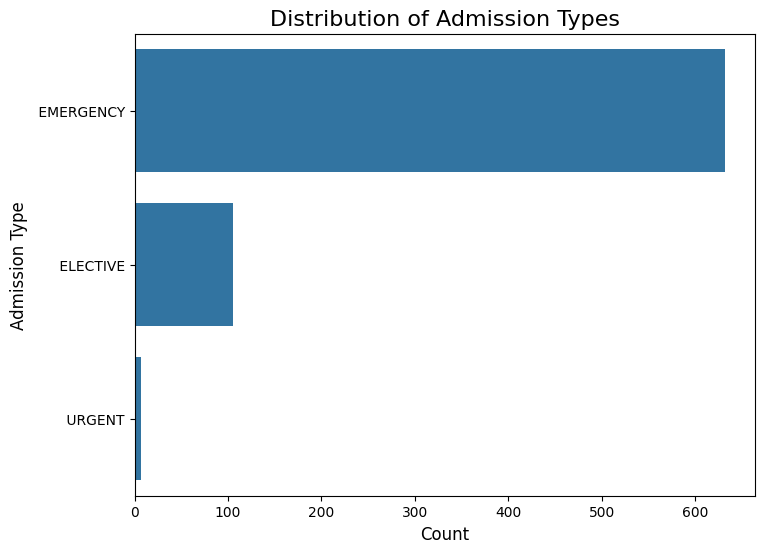

C:\Users\PAVANI\AppData\Local\Temp\ipykernel_3148\3565745123.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_diagnoses.values, y=top_diagnoses.index, palette="viridis")


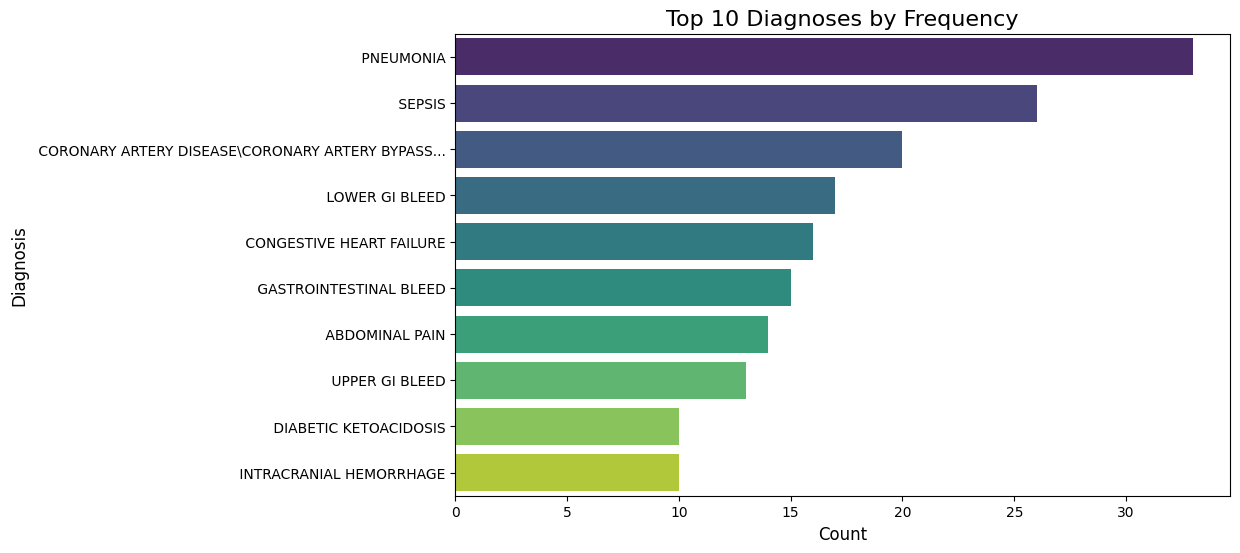

In [23]:
# Visualize admission type distribution
plt.figure(figsize=(8, 6))
sns.countplot(y="ADMISSION_TYPE", data=data, order=data['ADMISSION_TYPE'].value_counts().index)
plt.title("Distribution of Admission Types", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Admission Type", fontsize=12)
plt.show()

# Visualize top diagnoses by frequency
top_diagnoses = data['DIAGNOSIS'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_diagnoses.values, y=top_diagnoses.index, palette="viridis")
plt.title("Top 10 Diagnoses by Frequency", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Diagnosis", fontsize=12)
plt.show()

C:\Users\PAVANI\AppData\Local\Temp\ipykernel_3148\3813401487.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")


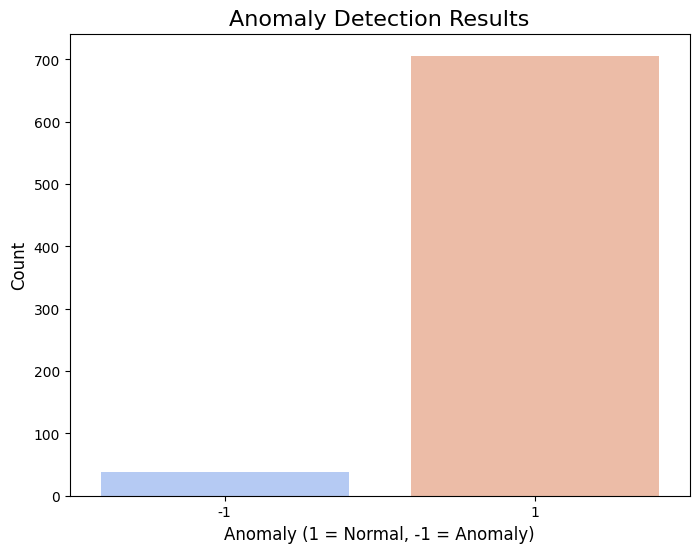

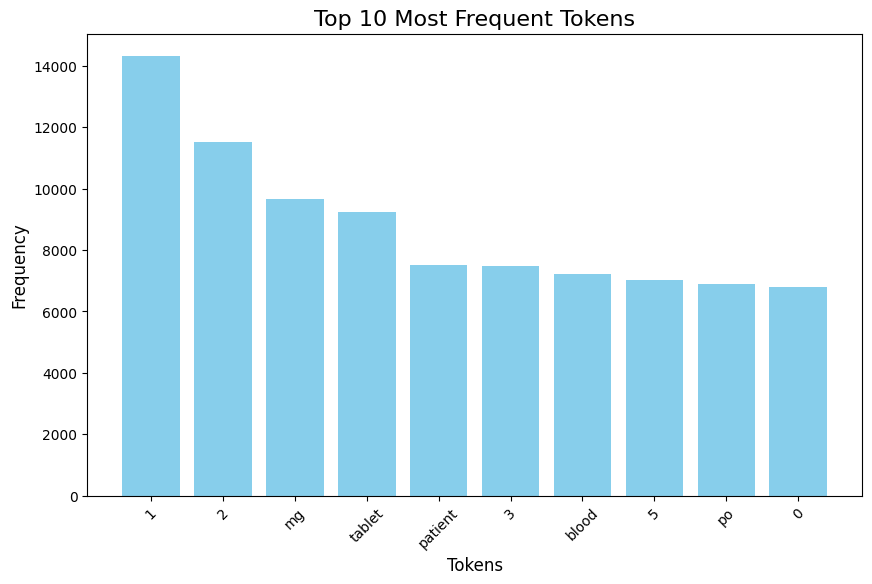

In [24]:
# Anomaly Detection using Isolation Forest
# Convert cleaned text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
feature_vectors = tfidf_vectorizer.fit_transform(data['processed_text'])

# Apply Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
anomalies = model.fit_predict(feature_vectors)

# Add anomaly results to the DataFrame (1 for normal, -1 for anomaly)
data['anomaly'] = anomalies

# Visualize anomalies
anomaly_counts = data['anomaly'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="coolwarm")
plt.title("Anomaly Detection Results", fontsize=16)
plt.xlabel("Anomaly (1 = Normal, -1 = Anomaly)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Visualize top tokens by frequency
all_tokens = ' '.join(data['processed_text']).split()
token_counts = Counter(all_tokens).most_common(10)

# Plot top tokens
words, counts = zip(*token_counts)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color="skyblue")
plt.title("Top 10 Most Frequent Tokens", fontsize=16)
plt.xlabel("Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.show()
